## 1. Load CIFAR-100 Database

In [1]:
import keras
from keras.datasets import cifar100
(x_train_raw, y_train_raw), (x_test, y_test) = cifar100.load_data(label_mode='fine')

Using TensorFlow backend.


## 2. Visualize the First 24 Training Images

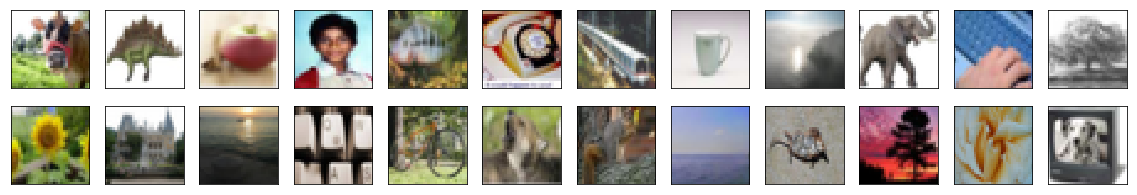

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(24):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train_raw[i]))

## 3. Rescale the Image by Dividing Every Pixel in Every Image by 255

In [3]:
# rescale [0, 255] => [0,1]
x_train_raw = x_train_raw.astype('float32')/255
x_test = x_test.astype('float32')/255

## 4. Break Dataset into Training, Testing and Validation Sets

In [4]:
from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train_raw[5000:], x_train_raw[:5000]
(y_train, y_valid) = y_train_raw[5000:], y_train_raw[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


## 5. Create and Configure Augmented Image Generator

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

## 6. Visualize Original and Augmented Images

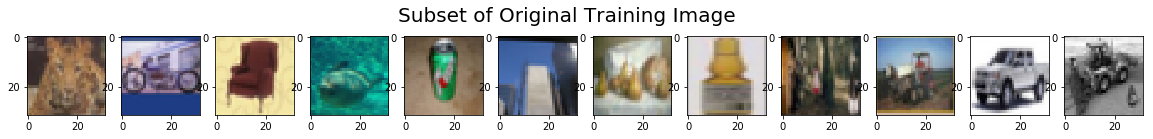

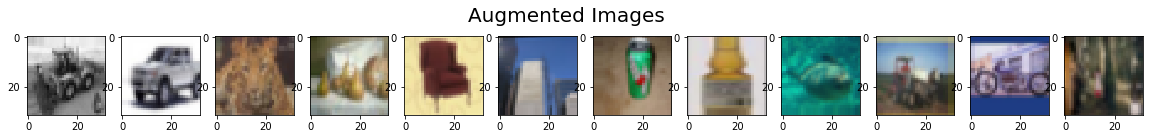

In [6]:
import matplotlib.pyplot as plt
# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Image', fontsize = 20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

## 7. Define the Model Architecture

In [7]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint 

epochs = 20
batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

#model.fit(x_train, y_train,
#          validation_data=(x_valid, y_valid),
#          epochs=epochs, batch_size=batch_size,
#          callbacks=[checkpointer], verbose=2)

model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=x_train.shape[0],
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(x_valid, y_valid))

Epoch 1/20


KeyboardInterrupt: 

In [23]:
from keras.applications.mobilenetv2 import MobileNetV2

mn_model = MobileNetV2(weights=None, include_top=False, 
             input_shape=x_train.shape[1:], classes=10)

mn_model.summary()

ModuleNotFoundError: No module named 'keras.applications.mobilenetv2'

In [13]:
print(keras.__version__)

2.1.5
